# Наивный Байес и спам
__Суммарное количество баллов: 10__


In [11]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
#import spacy
from nltk.stem.snowball import SnowballStemmer

In [12]:
import re
def read_dataset(filename):
    file = open(filename, encoding="utf-8")
    x = []
    y = []
    for line in file:
        cl, sms = re.split("^(ham|spam)[\t\s]+(.*)$", line)[1:3]
        x.append(sms)
        y.append(cl)
    return np.array(x, dtype=np.str), np.array(y, dtype=np.str)

In [13]:
def get_precision_recall_accuracy(y_pred, y_true):
    classes = np.unique(list(y_pred) + list(y_true))
    true_positive = dict((c, 0) for c in classes)
    true_negative = dict((c, 0) for c in classes)
    false_positive = dict((c, 0) for c in classes)
    false_negative = dict((c, 0) for c in classes)
    for c_pred, c_true in zip(y_pred, y_true):
        for c in classes:
            if c_true == c:
                if c_pred == c_true:
                    true_positive[c] = true_positive.get(c, 0) + 1
                else:
                    false_negative[c] = false_negative.get(c, 0) + 1
            else:
                if c_pred == c:
                    false_positive[c] = false_positive.get(c, 0) + 1
                else:
                    true_negative[c] = true_negative.get(c, 0) + 1
    precision = dict((c, true_positive[c] / (true_positive[c] + false_positive[c])) for c in classes)
    recall = dict((c, true_positive[c] / (true_positive[c] + false_negative[c])) for c in classes)
    accuracy = sum([true_positive[c] for c in classes]) / len(y_pred)
    return precision, recall, accuracy

def plot_precision_recall(X_train, y_train, X_test, y_test, bow_method, voc_sizes=range(4, 200, 5)):
    classes = np.unique(list(y_train) + list(y_test))
    precisions = dict([(c, []) for c in classes])
    recalls = dict([(c, []) for c in classes])
    accuracies = []
    for v in voc_sizes:
        bow = bow_method(X_train, voc_limit=v)
        X_train_transformed = bow.transform(X_train)
        X_test_transformed = bow.transform(X_test)
        classifier = NaiveBayes(0.001)
        classifier.fit(X_train_transformed, y_train)
        y_pred = classifier.predict(X_test_transformed)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in classes:
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("Vocabulary size")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(list(ys.values()))-0.01, np.max(list(ys.values()))+0.01)
        for c in ys.keys():
            plt.plot(x, ys[c], label="Class " + str(c))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(voc_sizes, recalls, "Recall")
    plot(voc_sizes, precisions, "Precision")
    plot(voc_sizes, {"":accuracies}, "Accuracy", legend=False)

In [14]:
X, y = read_dataset("hw6_data/spam")

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

['Talk With Yourself Atleast Once In A Day...!!! Otherwise You Will Miss Your Best FRIEND In This WORLD...!!! -Shakespeare- SHESIL  &lt;#&gt;'
 'You will be in the place of that man'
 'Thanks 4 your continued support Your question this week will enter u in2 our draw 4 £100 cash. Name the NEW US President? txt ans to 80082'
 ...
 'Natalja (25/F) is inviting you to be her friend. Reply YES-440 or NO-440 See her: www.SMS.ac/u/nat27081980 STOP? Send STOP FRND to 62468'
 'We tried to contact you re our offer of New Video Phone 750 anytime any network mins HALF PRICE Rental camcorder call 08000930705 or reply for delivery Wed'
 'Ü give me some time to walk there.']


### Задание 1 (3 балла)
Реализуйте классификацию методом Байеса в предположении независимости компонент `x`. При реализации следует считать, что значения каждой компоненты дискретны, а `p(x|y)` имеет мультиномиальное распределение.

#### Методы
`fit(X, y)` - оценивает параметры распределения `p(x|y)` для каждого `y`. 

`log_proba(X)` - для каждого элемента набора `X` считает логарифм вероятности отнести его к каждому классу. По теореме Байеса: `p(y|x) = p(y)p(x|y)/p(x)`. Соответственно, после логарифмирования: `log p(y|x) = log p(y) + log p(x|y) - log p(x)`. Поскольку `log p(x)` является независящей от класса `y` константой, это слагаемое никак не влияет на решение задачи максимизации. Поэтому его можно просто убрать для простоты.

In [73]:
from collections import Counter

class NaiveBayes:
    def __init__(self, alpha):
        self.alpha = alpha # Параметр аддитивной регуляризации
    
    def fit(self, X, y):
        self.py = Counter(y)
        self.classes = dict(zip(range(len(self.py.keys())), self.py.keys()))
        self.pxy = dict() # feat -> {x -> {y -> cnt}}
        for row, cl in zip(X, y):
            for i, f in enumerate(row):
                if i not in self.pxy:
                    self.pxy[i] = dict()
                if f not in self.pxy[i]:
                    self.pxy[i][f] = dict()
                if cl not in self.pxy[i][f]:
                    self.pxy[i][f][cl] = 0
                self.pxy[i][f][cl] += 1
        
        total = sum(self.py.values())
        self.py = {k : v/total for k,v in self.py.items()}
        for feat, row in self.pxy.items():
            for x, vals in row.items():
                self.pxy[feat][x] = {cl : v/self.py[cl] for cl,v in vals.items()}
        
    def predict(self, X):
        return [self.classes[i] for i in np.argmax(self.log_proba(X), axis=1)]
    
    def log_proba(self, X):
        ans = np.zeros((X.shape[0], len(self.classes)))
        for i, row in enumerate(X):
            for cl in range(len(self.classes.keys())):
                ans[i][cl] = np.log(self.py[self.classes[cl]]) + sum([np.log(self.pxy[i].get(x, dict()).get(self.classes[cl], self.alpha)) for i, x in enumerate(row)])
        return ans

### Задание 2 (3 балла)
Теперь реализуем метод bag of words. Задача состоит в том, чтобы посчитать количество вхождений каждого слова в предложение.

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [74]:
class BoW:
    def __init__(self, X, voc_limit=1000):
        c = Counter()
        for row in X:
            c.update(row.split())
        self.bow = dict() # word -> pos
        for i, (k, v) in enumerate(sorted(c.items(), key=lambda x: x[1], reverse=True)[:voc_limit]):
            self.bow[k] = i
        
    def transform(self, X):
        ans = np.zeros((X.shape[0], len(self.bow)))
        for i, row in enumerate(X):
            for w in row.split():
                t = self.bow.get(w, -1)
                if t == -1:
                    pass
                else:
                    ans[i][t] += 1
        return ans

In [75]:
bow = BoW(X_train, voc_limit=500)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)

In [76]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bow, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bow), y_test)

({'ham': 0.9755600814663951, 'spam': 0.9701492537313433},
 {'ham': 0.9958419958419958, 'spam': 0.8441558441558441},
 0.974910394265233)

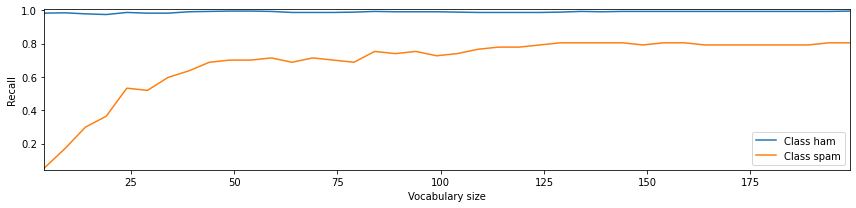

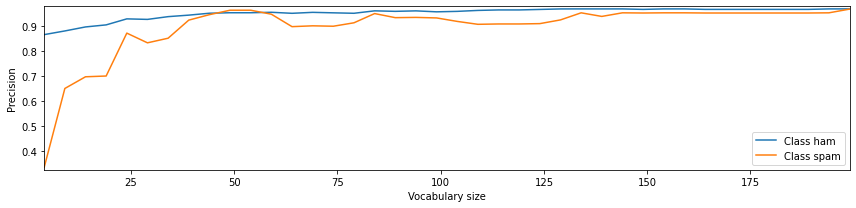

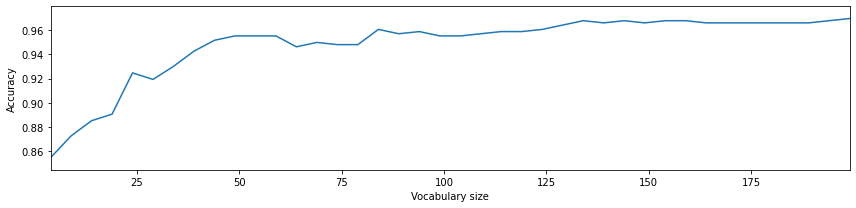

In [77]:
plot_precision_recall(X_train, y_train, X_test, y_test, BoW)

### Задание 3 (2 балла)
Теперь добавим в BoW стемминг. Для этого нам понадобится класс SnowballStemmer из пакета `nltk`

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [82]:
class BowStem:
    def __init__(self, X, voc_limit=1000):
        self.stemmer = SnowballStemmer("english")
        c = Counter()
        for row in X:
            c.update([self.stemmer.stem(i) for i in row.split()])
        self.bow = dict() # word -> pos
        for i, (k, v) in enumerate(sorted(c.items(), key=lambda x: x[1], reverse=True)[:voc_limit]):
            self.bow[k] = i
        
    def transform(self, X):
        ans = np.zeros((X.shape[0], len(self.bow)))
        for i, row in enumerate(X):
            for w in [self.stemmer.stem(i) for i in row.split()]:
                t = self.bow.get(w, -1)
                if t == -1:
                    pass
                else:
                    ans[i][t] += 1
        return ans

In [83]:
bows = BowStem(X_train, voc_limit=500)
X_train_bows = bows.transform(X_train)
X_test_bows = bows.transform(X_test)

In [84]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bows, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bows), y_test)

({'ham': 0.9696969696969697, 'spam': 0.9841269841269841},
 {'ham': 0.997920997920998, 'spam': 0.8051948051948052},
 0.9713261648745519)

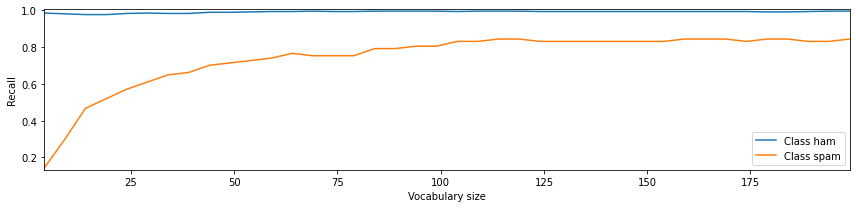

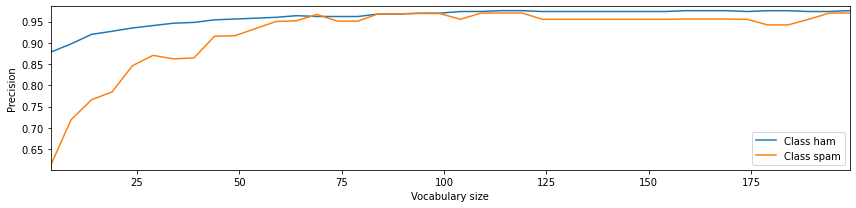

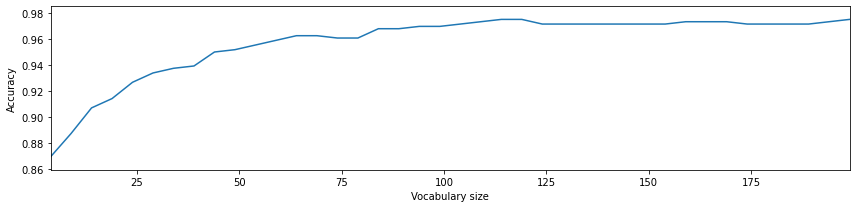

In [85]:
plot_precision_recall(X_train, y_train, X_test, y_test, BowStem)